## Purpose

Cluster time series using DBSCAN

In [1]:
import os 
import sys
import numpy as np
from collections import defaultdict
import CAN_objects.aid_message
import matplotlib.pyplot as plt


actt_path = os.path.join(os.path.join(os.path.expanduser("~"), "Projects", "CAN", "actt"))
os.chdir(actt_path)
sys.path.insert(0, "src") # add src folder to path so that files from this folder can be imported

from generalFunctions import unpickle
import subprocess

import importlib
importlib.reload(CAN_objects.aid_message)
from init_cancapture_from_canlog import init_cancap
import json
import seaborn as sns
import pandas as pd

from CAN_objects.capture import MappedCapture, MatchedCapture
import math
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, linkage, fcluster

from pprint import pprint
from sklearn.metrics.cluster import normalized_mutual_info_score

from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

import glob
from tqdm import tqdm
import itertools
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, spearmanr
from sklearn.preprocessing import normalize, scale, MinMaxScaler, StandardScaler

from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors

## Enable the Use of Functions From the Detect Repo

In [2]:
# sys.path.insert(0, "/home/cades/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
sys.path.insert(0, "/home/cloud/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
import signal_based_preprocess_functions
print(os.getcwd())

/home/cloud/Projects/CAN/actt


## Functions

In [3]:
def from_capture_to_time_series(cap, ground_truth_dbc_path, freq):
    
    signal_multivar_ts, timepts, aid_signal_tups = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap, ground_truth_dbc_path, min_hz_msgs=freq)

    return signal_multivar_ts, timepts, aid_signal_tups


def from_captures_to_time_series(cap_1, cap_2, ground_truth_dbc_path):
        
    signal_multivar_ts_1, timepts_1, aid_signal_tups_1 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_1, ground_truth_dbc_path)
    signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_2, ground_truth_dbc_path)

    return signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2


def from_single_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    display(df_1)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df_1)
    # df_1.dtypes
    
    # df_1_scaled = normalize(df_1) # scale
    df_1_scaled = (df_1-df_1.min())/(df_1.max()-df_1.min())
    df_1_scaled = pd.DataFrame(df_1_scaled, columns=df_1.columns)
    df_1 = df_1_scaled
    display(df_1)

    # Compute correlation matrix
    corr_matrix_1 = df_1.corr(method="pearson")
    # display(corr_matrix_1)
    # display(corr_matrix_1.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_1 = corr_matrix_1.columns.values

    
    return corr_matrix_1, signal_names_1


def from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    display(df_1)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df_1)
    # df_1.dtypes
    
    # df_1_scaled = normalize(df_1) # scale
    df_standardized = (df-df.mean())/df.std()
    df_1_scaled = pd.DataFrame(df_1_scaled, columns=df_1.columns)
    df_1 = df_1_scaled
    display(df_1)

    # Compute correlation matrix
    corr_matrix_1 = df_1.corr(method="pearson")
    # display(corr_matrix_1)
    # display(corr_matrix_1.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_1 = corr_matrix_1.columns.values
    # print(len(signal_names_training), signal_names_training)
    
    ##################
    # Second dataframe
    # Convert matrix of time series into a dataframe
    df_2 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_2[:,index] for index, tup in enumerate(aid_signal_tups_2)})
    # display(df)

    # Remove columns with constant values
    df_2 = df_2.loc[:, (df_2 != df_2.iloc[0]).any()] 
    # display(df_2)
    # df_2.dtypes
    
    df_2_scaled = normalize(df_2) # scale
    df_2_scaled = pd.DataFrame(df_2_scaled, columns=df_2.columns)
    df_2 = df_2_scaled
    # display(df_2)

    # Compute correlation matrix
    corr_matrix_2 = df_2.corr(method="pearson")
    # display(corr_matrix_2)
    # display(corr_matrix_2.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_2 = corr_matrix_2.columns.values
    # print(len(signal_names_training), signal_names_training)
    
    signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))
    
    return corr_matrix_1, corr_matrix_2, signal_names_intersection


def compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method):
    
    # Filter correlation matrices by common names
    corr_matrix_1 = corr_matrix_1.loc[signal_names_intersection, signal_names_intersection]
    # display(corr_matrix_1)

    corr_matrix_2 = corr_matrix_2.loc[signal_names_intersection, signal_names_intersection]
    # display(corr_matrix_2)
    
    linkage_matrix_1 = hierarchical_clustering(corr_matrix_1, method=method)
    linkage_matrix_2 = hierarchical_clustering(corr_matrix_2, method=method)
    
    return linkage_matrix_1, linkage_matrix_2


def compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=1.0):
    
    c_1 = Clustering().from_scipy_linkage(linkage_matrix_1, dist_rescaled=True)
    c_2 = Clustering().from_scipy_linkage(linkage_matrix_2, dist_rescaled=True)
    
    return sim.element_sim(c_1, c_2, r=r, alpha=0.9)


def compute_distribution_training(training_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for row in tqdm(range(len(training_captures))):
    
        for column in range(row, len(training_captures)):

            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(training_captures[row], training_captures[column], ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(training_captures[row], training_captures[column]), similarity])

    print(pairs)

    with open(f"./similarity_matrix_training.json", "w") as f:
        json.dump(pairs, f)


def compute_distribution_mixed(training_captures, testing_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for interest_capture in tqdm(training_captures):
        for capture in testing_captures:
        
            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(interest_capture, capture, ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(interest_capture, capture), similarity])
        
    print(pairs)

    with open(f"./similarity_matrix_mixed.json", "w") as f:
        json.dump(pairs, f)


def compute_distribution_testing(testing_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for row in tqdm(range(len(testing_captures))):
    
        for column in range(row, len(testing_captures)):

            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(testing_captures[row], testing_captures[column], ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(testing_captures[row], testing_captures[column]), similarity])

    print(pairs)

    with open(f"./similarity_matrix_testing.json", "w") as f:
        json.dump(pairs, f)


def remove_constant_signals(signal_multivar_ts):
    return signal_multivar_ts[:, ~np.all(signal_multivar_ts[1:] == signal_multivar_ts[:-1], axis=0)]


def partition_time_series(signal_multivar_ts, window_length, offset):
    
    n = signal_multivar_ts.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(signal_multivar_ts[i: i + window_length,:])
        i = i + offset
        
    if i != n:
        partition.append(signal_multivar_ts[i:n,:])
        
    return partition
    
    
def process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts[:,index] for index, tup in enumerate(aid_signal_tups)})
    # display(df)

    # Remove columns with constant values
    df = df.loc[:, (df != df.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    # df_standardized = (df-df.mean())/df.std()
    df_standardized = (df-df.min())/(df.max()-df.min())
    # display(df_standardized)
    
    # Partition of data frames
    n = df_standardized.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(df_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition.append(df_standardized.iloc[i:n, :])
        
    return partition


def process_multiple_multivariate_signals(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    # display(df)
    print(df_1.shape)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_1_standardized = (df_1-df_1.mean())/df_1.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_1_standardized.shape[0]
    i = 0
    partition_1 = []
    
    while (i + window_length) < n:
        partition_1.append(df_1_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_1.append(df_1_standardized.iloc[i:n, :])
        
        
    # Second dataframe
    # Convert matrix of time series into a dataframe
    df_2 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_2[:,index] for index, tup in enumerate(aid_signal_tups_2)})
    # display(df)
    print(df_2.shape)

    # Remove columns with constant values
    df_2 = df_2.loc[:, (df_2 != df_2.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_2_standardized = (df_2-df_2.mean())/df_2.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_2_standardized.shape[0]
    i = 0
    partition_2 = []
    
    while (i + window_length) < n:
        partition_2.append(df_2_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_2.append(df_2_standardized.iloc[i:n, :])
        
    return partition_1, partition_2


def upper(df):
    '''Returns the upper triangle of a correlation matrix (excluding diagonal).
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df) == np.ndarray)
    except:
        if type(df) == pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    
    return df[mask]



def randomized_test_permutations(m1, m2):
    """Nonparametric permutation testing Monte Carlo"""
    np.random.seed(0)
    rhos = []
    n_iter = 100
    true_rho, _ = spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for iter in range(n_iter):
        np.random.shuffle(m_ids) # shuffle list 
        r, _ = spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
        rhos.append(r)
    perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test

    return perm_p


def compute_correlation_matrices(partition):
    
    corr_matrices = []

    for df in partition:

        # Remove columns with constant values
        df = df.loc[:, (df != df.iloc[0]).any()] 

        # Compute correlation matrix
        corr_matrices.append(df.corr(method="pearson"))
        
    return corr_matrices


def compute_similarity_from_correlation_matrices(corr_matrices):
    
    similarities = []
    
    for i in range(len(corr_matrices)-1):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices[i].columns.values
        signal_names_2 = corr_matrices[i+1].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices[i+1].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
    return similarities


def compute_similarity_from_multiple_correlation_matrices(corr_matrices_1, corr_matrices_2):
    
    similarities = []
    
    if len(corr_matrices_1) <= len(corr_matrices_2):
        corr_matrices_reference = corr_matrices_1
    else:
        corr_matrices_reference = corr_matrices_2
        
    print(len(corr_matrices_reference))
            
    for i in range(len(corr_matrices_reference)):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices_1[i].columns.values
        signal_names_2 = corr_matrices_2[i].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices_1[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices_2[i].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        # similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
        correlation = spearmanr(upper(df_1), upper(df_2))[0]
        p_value = spearmanr(upper(df_1), upper(df_2))[1]
        
        if p_value > 0.05:
            similarities.append((i, correlation, p_value))
        else:
            similarities.append(i)
            
        
    return similarities



def create_time_intervals(total_length, window, offset):
    
    # Partition of data frames
    i = 0
    intervals = []
    
    while (i + window) < total_length:
        intervals.append((i, i + window))
        i = i + offset
        
    if i != total_length:
        intervals.append((i , total_length))
        
    return intervals


    # # Partition of data frames
    # n = df_standardized.shape[0]
    # i = 0
    # partition = []
    
    # while (i + window_length) < n:
    #     partition.append(df_standardized.iloc[i:i + window_length, :])
    #     i = i + offset
        
    # if i != n:
    #     partition.append(df_standardized.iloc[i:n, :])
        
    # return partition
    

    # intervals = []
    # # offset = 0.1*offset
    
    # for i in np.arange(0, total_length - window + 1, offset, dtype=float):
    #     intervals.append((i, i + window))

    # if i + window < total_length:
    #     intervals.append((i + offset, total_length))

    # return intervals 


def compute_distance_matrix(corr_matrix):

    signal_names = np.array(corr_matrix.columns)

    # display(corr_matrix)

    # compute distance matrix
    # distance_matrix = np.sqrt(2*(1 - corr_matrix.to_numpy())) 
    distance_matrix = 2*(1 - corr_matrix.to_numpy())
    distance_matrix[distance_matrix < 0] = 0
    # display(distance_matrix.shape)
    # display(distance_matrix)

    return signal_names, distance_matrix

## Loading the Data

In [4]:
ground_truth_dbc_path = os.path.join(actt_path, "metadata", "dbcs", "heuristic_labeled", "anonymized_020822_030640.dbc")

# training_captures = [directory for directory in os.listdir("/home/cades/Projects/CAN/actt/data-cancaptures/") if ("road_ambient_dyno" in directory) or ("road_ambient_highway" in directory)]
training_captures = [directory for directory in os.listdir("/home/cloud/Projects/CAN/actt/data-cancaptures/") if ("road_ambient_dyno" in directory) or ("road_ambient_highway" in directory)]
print(len(training_captures), training_captures)  

testing_captures = ["correlated_masquerade_1_030804_082640", "correlated_masquerade_2_031128_011320", "correlated_masquerade_3_040322_190000", 
                    "road_attack_max_speedometer_attack_1_masquerade_060215_054000", "road_attack_max_speedometer_attack_2_masquerade_060611_002640", 
                    "road_attack_max_speedometer_attack_3_masquerade_061004_181320", "road_attack_max_engine_coolant_temp_attack_masquerade_041109_063320",
                    "road_attack_reverse_light_on_attack_1_masquerade_091205_030000", "road_attack_reverse_light_on_attack_2_masquerade_100330_214640", 
                    "road_attack_reverse_light_on_attack_3_masquerade_100724_153320", "road_attack_reverse_light_off_attack_1_masquerade_080110_162000", 
                    "road_attack_reverse_light_off_attack_2_masquerade_080505_110640", "road_attack_reverse_light_off_attack_3_masquerade_080829_045320"]

print(len(testing_captures), testing_captures) 

12 ['road_ambient_dyno_drive_basic_short_020822_030640', 'road_ambient_dyno_idle_radio_infotainment_030410_144000', 'road_ambient_dyno_drive_winter_030410_144000', 'road_ambient_highway_street_driving_diagnostics_031128_011320', 'road_ambient_dyno_drive_extended_short_021215_195320', 'road_ambient_highway_street_driving_long_050305_002000', 'road_ambient_dyno_drive_extended_long_040716_134640', 'road_ambient_dyno_drive_benign_anomaly_030804_082640', 'road_ambient_dyno_exercise_all_bits_030410_144000', 'road_ambient_dyno_reverse_040322_190000', 'road_ambient_dyno_drive_radio_infotainment_041109_063320', 'road_ambient_dyno_drive_basic_long_050305_002000']
13 ['correlated_masquerade_1_030804_082640', 'correlated_masquerade_2_031128_011320', 'correlated_masquerade_3_040322_190000', 'road_attack_max_speedometer_attack_1_masquerade_060215_054000', 'road_attack_max_speedometer_attack_2_masquerade_060611_002640', 'road_attack_max_speedometer_attack_3_masquerade_061004_181320', 'road_attack_max

## Obtain Metadata

In [5]:
# with open("/home/cades/Projects/CAN/actt/data/capture_metadata.json") as f:
with open("/home/cloud/Projects/CAN/actt/data/capture_metadata.json") as f:
    attack_metadata = json.load(f)
    
# pprint(testing_captures)
# pprint(attack_metadata)

attack_metadata_keys = ["correlated_signal_attack_1_masquerade", "correlated_signal_attack_2_masquerade", "correlated_signal_attack_3_masquerade", 
                        "max_speedometer_attack_1_masquerade", "max_speedometer_attack_2_masquerade", "max_speedometer_attack_3_masquerade",
                        "max_engine_coolant_temp_attack_masquerade", "reverse_light_on_attack_1_masquerade", "reverse_light_on_attack_2_masquerade",
                        "reverse_light_on_attack_3_masquerade", "reverse_light_off_attack_1_masquerade", "reverse_light_off_attack_2_masquerade",
                        "reverse_light_off_attack_3_masquerade"]

print(len(attack_metadata_keys))

13


## Experiments on a Single Capture

In [6]:
print(attack_metadata_keys[0])
display(attack_metadata[attack_metadata_keys[0]])

correlated_signal_attack_1_masquerade


{'description': 'start from driving; accelerate; start injecting; car rolls to stop; stop injecting; accelerate',
 'elapsed_sec': 33.101852,
 'injection_data_str': '595945450000FFFF',
 'injection_id': '0x6e0',
 'injection_interval': [9.191851, 30.050109],
 'modified': True,
 'on_dyno': True}

In [7]:
signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[0], ground_truth_dbc_path, freq=100) 

In [8]:
signal_multivar_ts.shape

(3400, 47)

In [9]:
signal_multivar_ts

array([[   74,     1, 15165, ...,   435,   429,   431],
       [   74,     1, 15165, ...,   435,   429,   431],
       [   74,     1, 15165, ...,   435,   431,   432],
       ...,
       [   79,     1, 14792, ...,   262,   262,   262],
       [   79,     1, 14792, ...,   262,   262,   262],
       [   79,     1, 14792, ...,   262,   262,   262]])

In [10]:
timepts[-1]/60

0.5665

In [11]:
np.diff(timepts)

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01])

In [12]:
corr_matrix, signal_names = from_single_series_to_correlation_matrix(signal_multivar_ts, aid_signal_tups)

,14_0,14_1,14_2,51_0,51_1,51_2,51_3,51_4,51_5,51_6,...,1505_0,1505_1,1505_2,1505_3,1505_4,1505_5,1760_0,1760_1,1760_2,1760_3
0,74,1,15165,0,-45,0,3,9,32,125,...,510,2,3,1,0,32846,438,435,429,431
1,74,1,15165,0,-45,0,3,9,32,125,...,510,2,3,1,0,32846,438,435,429,431
2,74,1,15165,0,-46,0,3,10,32,125,...,510,2,3,1,0,32846,438,435,431,432
3,74,1,15162,0,-47,0,3,11,32,125,...,510,2,3,1,0,32846,438,435,431,432
4,74,1,15165,0,-48,0,3,12,32,125,...,510,2,3,1,0,32847,442,440,433,432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,79,1,14792,751,-11,6024,3,7,0,125,...,511,1,3,1,0,32842,265,262,262,262
3396,79,1,14792,751,-11,6024,3,7,0,125,...,511,1,3,1,0,32842,265,262,262,262
3397,79,1,14792,751,-11,6024,3,7,0,125,...,511,1,3,1,0,32842,265,262,262,262
3398,79,1,14792,751,-11,6024,3,7,0,125,...,511,1,3,1,0,32842,265,262,262,262


,14_0,14_2,51_0,51_1,51_2,51_4,51_5,51_6,167_3,167_4,...,852_0,852_2,852_3,1505_0,1505_1,1505_5,1760_0,1760_1,1760_2,1760_3
0,0.333333,0.678022,0.000000,0.325490,0.00000,0.600000,0.032291,0.636364,0.000000,0.376543,...,0.452632,0.518519,0.571429,0.994444,1.0,0.890411,0.067499,0.322461,0.459807,0.026308
1,0.333333,0.678022,0.000000,0.325490,0.00000,0.600000,0.032291,0.636364,0.000000,0.376543,...,0.452632,0.518519,0.571429,0.994444,1.0,0.890411,0.067499,0.322461,0.459807,0.026308
2,0.333333,0.678022,0.000000,0.321569,0.00000,0.666667,0.032291,0.636364,0.000000,0.382716,...,0.452632,0.500000,0.714286,0.994444,1.0,0.890411,0.067499,0.322461,0.461951,0.026369
3,0.333333,0.674725,0.000000,0.317647,0.00000,0.733333,0.032291,0.636364,0.000000,0.376543,...,0.452632,0.500000,0.714286,0.994444,1.0,0.890411,0.067499,0.322461,0.461951,0.026369
4,0.333333,0.678022,0.000000,0.313725,0.00000,0.800000,0.032291,0.636364,0.000000,0.376543,...,0.452632,0.490741,0.785714,0.994444,1.0,0.897260,0.068115,0.326168,0.464094,0.026369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,0.888889,0.268132,0.982984,0.458824,0.98351,0.466667,0.000000,0.636364,0.666667,0.592593,...,0.273684,0.694444,0.428571,1.000000,0.0,0.863014,0.040838,0.194218,0.280815,0.015992
3396,0.888889,0.268132,0.982984,0.458824,0.98351,0.466667,0.000000,0.636364,0.666667,0.592593,...,0.273684,0.694444,0.428571,1.000000,0.0,0.863014,0.040838,0.194218,0.280815,0.015992
3397,0.888889,0.268132,0.982984,0.458824,0.98351,0.466667,0.000000,0.636364,0.666667,0.592593,...,0.273684,0.694444,0.428571,1.000000,0.0,0.863014,0.040838,0.194218,0.280815,0.015992
3398,0.888889,0.268132,0.982984,0.458824,0.98351,0.466667,0.000000,0.636364,0.666667,0.592593,...,0.273684,0.694444,0.428571,1.000000,0.0,0.863014,0.040838,0.194218,0.280815,0.015992


In [13]:
corr_matrix

,14_0,14_2,51_0,51_1,51_2,51_4,51_5,51_6,167_3,167_4,...,852_0,852_2,852_3,1505_0,1505_1,1505_5,1760_0,1760_1,1760_2,1760_3
14_0,1.000000,-0.984134,0.893785,0.283334,0.888130,0.005733,-0.161662,0.058156,0.766495,0.867449,...,-0.793092,0.786857,0.014927,0.748853,-0.914460,-0.184332,0.253752,0.011045,-0.610776,0.278756
14_2,-0.984134,1.000000,-0.875128,-0.265782,-0.868592,-0.010346,0.151242,-0.067608,-0.741896,-0.861008,...,0.778518,-0.771810,-0.019245,-0.708310,0.899536,0.254213,-0.335185,-0.099355,0.653480,-0.358833
51_0,0.893785,-0.875128,1.000000,0.179473,0.999231,0.005933,-0.113145,-0.121240,0.928190,0.915837,...,-0.845603,0.840454,0.009360,0.731150,-0.992099,-0.036873,0.163736,-0.026401,-0.454485,0.183586
51_1,0.283334,-0.265782,0.179473,1.000000,0.184261,-0.075760,0.271227,-0.011803,0.209173,0.139173,...,-0.376082,0.380701,-0.065282,0.379595,-0.181558,-0.278583,0.216664,0.119075,-0.323541,0.225870
51_2,0.888130,-0.868592,0.999231,0.184261,1.000000,0.005672,-0.099184,-0.130524,0.936468,0.910474,...,-0.849016,0.843851,0.008970,0.731015,-0.990655,-0.038463,0.166605,-0.024021,-0.457316,0.186488
51_4,0.005733,-0.010346,0.005933,-0.075760,0.005672,1.000000,0.022849,-0.012762,0.011041,-0.005654,...,-0.017686,-0.102605,0.898457,0.012675,-0.006467,-0.024671,0.021407,0.020150,-0.016794,0.021388
51_5,-0.161662,0.151242,-0.113145,0.271227,-0.099184,0.022849,1.000000,-0.106254,0.114132,-0.241384,...,-0.235978,0.231458,0.013800,0.000821,0.139543,-0.345042,0.367362,0.357711,-0.266655,0.365727
51_6,0.058156,-0.067608,-0.121240,-0.011803,-0.130524,-0.012762,-0.106254,1.000000,-0.235471,-0.077585,...,0.106838,-0.104485,-0.011885,-0.008231,0.077012,0.049239,-0.080513,-0.073595,0.067040,-0.080690
167_3,0.766495,-0.741896,0.928190,0.209173,0.936468,0.011041,0.114132,-0.235471,1.000000,0.793005,...,-0.845072,0.838764,0.011709,0.677492,-0.900268,-0.067862,0.203089,0.018663,-0.470881,0.222017
167_4,0.867449,-0.861008,0.915837,0.139173,0.910474,-0.005654,-0.241384,-0.077585,0.793005,1.000000,...,-0.733997,0.730300,-0.003254,0.656769,-0.915759,0.006135,0.098488,-0.083519,-0.395509,0.117919


## Computing Distance Matrix

In [14]:
# https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering

# distance_matrix = 1 - corr_matrix.to_numpy()
# distance_matrix = np.sqrt(2*(1 - corr_matrix.to_numpy())) 
distance_matrix = 2*(1 - corr_matrix.to_numpy())
distance_matrix[distance_matrix < 0] = 0
display(distance_matrix.shape)
display(distance_matrix)

(32, 32)

array([[0.        , 3.96826855, 0.21243096, ..., 1.97790951, 3.22155271,
        1.44248786],
       [3.96826855, 0.        , 3.75025568, ..., 2.19870936, 0.69303991,
        2.71766538],
       [0.21243096, 3.75025568, 0.        , ..., 2.05280127, 2.90896919,
        1.63282794],
       ...,
       [1.97790951, 2.19870936, 2.05280127, ..., 0.        , 3.05874861,
        0.1472533 ],
       [3.22155271, 0.69303991, 2.90896919, ..., 3.05874861, 0.        ,
        3.61954337],
       [1.44248786, 2.71766538, 1.63282794, ..., 0.1472533 , 3.61954337,
        0.        ]])

In [15]:
print(np.min(distance_matrix), np.max(distance_matrix))

0.0 3.9841986724295504


## Clustering with DBSCAN

### Finding Optimal eps

In [16]:
neighb = NearestNeighbors(n_neighbors=2, metric="precomputed")
nbrs = neighb.fit(distance_matrix)

In [17]:
distances, indices = nbrs.kneighbors(distance_matrix)
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]

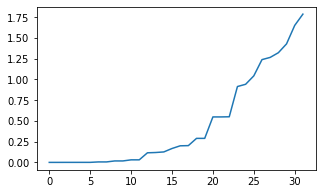

In [18]:
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [19]:
DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")
DBSCAN_clustering.fit(distance_matrix)

DBSCAN(eps=1, metric='precomputed', min_samples=1)

## DBSCAN Clustering Output

In [20]:
DBSCAN_clustering.labels_

array([ 0,  1,  0,  2,  0,  3,  4,  5,  0,  0,  6,  0,  1,  3,  1,  0,  0,
        1,  7,  8,  9, 10,  1,  0,  3,  0,  1,  1,  8,  8,  1,  8])

In [21]:
print(len(DBSCAN_clustering.labels_), np.count_nonzero(DBSCAN_clustering.labels_ == -1))

32 0


In [22]:
DBSCAN_clustering.labels_.max()

10

## Stream a Single Attack

In [27]:
window = 100
offset = 1

DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")

print("Processing: ", attack_metadata_keys[0])
signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[0], ground_truth_dbc_path, freq=100)
# print(signal_multivar_ts.shape)

partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset) # Partition time series
# print(len(partition_testing), partition_testing[0])

print("intervals: ", len(partition_testing))

# display(partition_testing[0])
# display(partition_testing[1])
# display(partition_testing[-1])

corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute correlation matrices
# display(corr_matrices_testing[0])

# total_length = int(np.ceil(timepts[-1]))
total_length = timepts[-1]
print("total length (s): ", total_length)  
intervals_testing = create_time_intervals(total_length, window/100, offset/100)
print(len(intervals_testing), intervals_testing)
print("attack interval (s): ", attack_metadata[attack_metadata_keys[0]]["injection_interval"][0], attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])

tp, fp, fn, tn = 0, 0, 0, 0

for index_interval in tqdm(range(len(intervals_testing))):

    # print("Interval: ", intervals_testing[index_interval])

    # print(np.isnan(corr_matrices_testing[index_interval]).any().any())
    # print((corr_matrices_testing[index_interval] < 0).any().any())

    # print(corr_matrices_testing[index_interval].shape)
    signal_names, distance_matrix = compute_distance_matrix(corr_matrices_testing[index_interval])
    # print(np.isnan(distance_matrix).any().any())
    # print((distance_matrix < 0))
    # display(distance_matrix[distance_matrix < 0])
    # print(type(signal_names), signal_names)
    
    DBSCAN_clustering.fit(distance_matrix)

    clustering_labels = DBSCAN_clustering.labels_
    
    unique_clustering_labels = np.unique(clustering_labels)

    # print(len(clustering_labels), len(unique_clustering_labels), clustering_labels)

    max_error_all_clusters = []

    for cluster_id in (unique_clustering_labels):
        
        index_of_interest = np.argwhere(clustering_labels == cluster_id).flatten()
        # print(cluster_id, len(index_of_interest), index_of_interest)
        # print(signal_names[index_of_interest])
        
        if len(index_of_interest) >= 2: # Check only clusters with at least two elements

            pd_corr_matrix = pd.DataFrame(corr_matrices_testing[index_interval], index=signal_names, columns=signal_names)
            # display(pd_distance_matrix)
            matrix_of_interest = pd_corr_matrix.loc[signal_names[index_of_interest], signal_names[index_of_interest]]
            # display(matrix_of_interest)

            upper_matrix_of_interest = upper(matrix_of_interest)
            # display(upper_matrix_of_interest)

            mean_cluster = np.mean(upper_matrix_of_interest)
            std_cluster = np.std(upper_matrix_of_interest)
            # print(std_cluster)

            if std_cluster != 0:

                error_cluster = np.absolute(upper_matrix_of_interest - mean_cluster)
                error_cluster = error_cluster/std_cluster
                max_error_cluster = np.max(error_cluster)
                
                max_error_all_clusters.append(max_error_cluster)

            # break

    mean_max_error_all_clusters = np.mean(max_error_all_clusters)
    std_max_error_all_clusters = np.std(max_error_all_clusters)
    
    # print("mean: ", mean_max_error_all_clusters, "std: ", std_max_error_all_clusters, "dist: ", max_error_all_clusters)
    
    # break

    if mean_max_error_all_clusters > 1.5: # positive detection
        if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
               or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                   or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            tp += 1
        else:
            fp += 1
    else: # negative detection
        if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
               or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                   or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            fn += 1
        else:
            tn += 1
            
# precision
if tp + fp != 0:            
    precision = tp/(tp + fp)
else:
    precision = np.nan

# recall
if tp + fn != 0:
    recall = tp/(tp + fn)
else:
    recall = np.nan

# f1
if precision + recall != 0:
    f1 = 2*((precision*recall)/(precision + recall))

else:
    f1 = np.nan

# fpr
if fp + tn != 0:
    fpr = fp/(fp + tn)
else:
    fpr = np.nan

# fnr
if fn + tp != 0:
    fnr = fn/(fn + tp)
else:
    fnr = np.nan

# mcc
if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
    mcc = (tp*tn) - (fp*fn)
else:
    mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

Processing:  correlated_signal_attack_1_masquerade
intervals:  3301
total length (s):  33.99
3300 [(0, 1.0), (0.01, 1.01), (0.02, 1.02), (0.03, 1.03), (0.04, 1.04), (0.05, 1.05), (0.060000000000000005, 1.06), (0.07, 1.07), (0.08, 1.08), (0.09, 1.09), (0.09999999999999999, 1.1), (0.10999999999999999, 1.1099999999999999), (0.11999999999999998, 1.1199999999999999), (0.12999999999999998, 1.13), (0.13999999999999999, 1.14), (0.15, 1.15), (0.16, 1.16), (0.17, 1.17), (0.18000000000000002, 1.18), (0.19000000000000003, 1.19), (0.20000000000000004, 1.2), (0.21000000000000005, 1.21), (0.22000000000000006, 1.22), (0.23000000000000007, 1.23), (0.24000000000000007, 1.24), (0.25000000000000006, 1.25), (0.26000000000000006, 1.26), (0.2700000000000001, 1.27), (0.2800000000000001, 1.28), (0.2900000000000001, 1.29), (0.3000000000000001, 1.3), (0.3100000000000001, 1.31), (0.3200000000000001, 1.32), (0.3300000000000001, 1.33), (0.34000000000000014, 1.34), (0.35000000000000014, 1.35), (0.36000000000000015, 

100%|██████████| 3300/3300 [00:15<00:00, 217.44it/s]

tp: 1127, tn: 217, fp: 897, fn: 1059
precision: 0.557, recall: 0.516, f1: 0.535, fpr: 0.805, fnr: 0.484, mcc: -0.281
positive_intervals: 2186.000, negative_intervals: 1114.000



## Stream All Attacks

In [28]:
window = 100
offset = 1

DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")

for index_attack in range(len(attack_metadata_keys)):

    print("Processing: ", attack_metadata_keys[index_attack])
    signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[index_attack], ground_truth_dbc_path, freq=100)
    
    partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset) # Partition time series

    print("intervals: ", len(partition_testing))

    # display(partition_testing[0])
    # display(partition_testing[1])
    # display(partition_testing[-1])

    corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute correlation matrices
    # display(corr_matrices_testing[0])

    # total_length = int(np.ceil(timepts[-1]))  
    total_length = timepts[-1]
    print("total length (s): ", total_length)
    intervals_testing = create_time_intervals(total_length, window/100, offset/100)
    # print(len(intervals_testing), intervals_testing)
    print("attack interval (s): ", attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0], attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])

    tp, fp, fn, tn = 0, 0, 0, 0

    for index_interval in range(len(intervals_testing)):

        # print("Interval: ", intervals_testing[index_interval])

        # print(np.isnan(corr_matrices_testing[index_interval]).any().any())
        # print((corr_matrices_testing[index_interval] < 0).any().any())

        # print(corr_matrices_testing[index_interval].shape)
        signal_names, distance_matrix = compute_distance_matrix(corr_matrices_testing[index_interval])
        # print(np.isnan(distance_matrix).any().any())
        # print((distance_matrix < 0))
        # display(distance_matrix[distance_matrix < 0])
        # print(type(signal_names), signal_names)
        
        DBSCAN_clustering.fit(distance_matrix)

        clustering_labels = DBSCAN_clustering.labels_
        
        unique_clustering_labels = np.unique(clustering_labels)

        # print(len(clustering_labels), len(unique_clustering_labels), clustering_labels)

        max_error_all_clusters = []

        for cluster_id in (unique_clustering_labels):
            
            index_of_interest = np.argwhere(clustering_labels == cluster_id).flatten()
            # print(cluster_id, len(index_of_interest), index_of_interest)
            # print(signal_names[index_of_interest])
            
            if len(index_of_interest) >= 2 and cluster_id != -1: # Check only clusters with at least two elements that are NOT outliers

                pd_corr_matrix = pd.DataFrame(corr_matrices_testing[index_interval], index=signal_names, columns=signal_names)
                # display(pd_distance_matrix)
                matrix_of_interest = pd_corr_matrix.loc[signal_names[index_of_interest], signal_names[index_of_interest]]
                # display(matrix_of_interest)

                upper_matrix_of_interest = upper(matrix_of_interest)
                # display(upper_matrix_of_interest)

                mean_cluster = np.mean(upper_matrix_of_interest)
                std_cluster = np.std(upper_matrix_of_interest)
                # print(std_cluster)

                if std_cluster != 0:

                    error_cluster = np.absolute(upper_matrix_of_interest - mean_cluster)
                    error_cluster = error_cluster/std_cluster
                    max_error_cluster = np.max(error_cluster)
                    
                    max_error_all_clusters.append(max_error_cluster)

                # break

        mean_max_error_all_clusters = np.mean(max_error_all_clusters)
        std_max_error_all_clusters = np.std(max_error_all_clusters)
        
        # print("mean: ", mean_max_error_all_clusters, "std: ", std_max_error_all_clusters, "dist: ", max_error_all_clusters)
        
        # break

        if mean_max_error_all_clusters > 1.5: # positive detection
            if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
                or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                    or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
                tp += 1
            else:
                fp += 1
        else: # negative detection
            if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
                or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                    or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
                fn += 1
            else:
                tn += 1
                
    # precision
    if tp + fp != 0:            
        precision = tp/(tp + fp)
    else:
        precision = np.nan

    # recall
    if tp + fn != 0:
        recall = tp/(tp + fn)
    else:
        recall = np.nan

    # f1
    if precision + recall != 0:
        f1 = 2*((precision*recall)/(precision + recall))

    else:
        f1 = np.nan

    # fpr
    if fp + tn != 0:
        fpr = fp/(fp + tn)
    else:
        fpr = np.nan

    # fnr
    if fn + tp != 0:
        fnr = fn/(fn + tp)
    else:
        fnr = np.nan

    # mcc
    if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
        mcc = (tp*tn) - (fp*fn)
    else:
        mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
    print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
    print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

Processing:  correlated_signal_attack_1_masquerade
intervals:  3301
total length (s):  33.99
attack interval (s):  9.191851 30.050109
tp: 1127, tn: 217, fp: 897, fn: 1059
precision: 0.557, recall: 0.516, f1: 0.535, fpr: 0.805, fnr: 0.484, mcc: -0.281
positive_intervals: 2186.000, negative_intervals: 1114.000

Processing:  correlated_signal_attack_2_masquerade
intervals:  2801
total length (s):  28.99
attack interval (s):  6.830477 28.225908
tp: 1042, tn: 98, fp: 722, fn: 938
precision: 0.591, recall: 0.526, f1: 0.557, fpr: 0.880, fnr: 0.474, mcc: -0.334
positive_intervals: 1980.000, negative_intervals: 820.000

Processing:  correlated_signal_attack_3_masquerade
intervals:  1601
total length (s):  16.99
attack interval (s):  4.318482 16.95706
tp: 209, tn: 716, fp: 104, fn: 572
precision: 0.668, recall: 0.268, f1: 0.382, fpr: 0.127, fnr: 0.732, mcc: 0.177
positive_intervals: 781.000, negative_intervals: 820.000

Processing:  max_speedometer_attack_1_masquerade
intervals:  8801
total leng

/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

tp: 506, tn: 523, fp: 297, fn: 1174
precision: 0.630, recall: 0.301, f1: 0.408, fpr: 0.362, fnr: 0.699, mcc: -0.061
positive_intervals: 1680.000, negative_intervals: 820.000

Processing:  reverse_light_on_attack_1_masquerade
intervals:  5401
total length (s):  54.99
attack interval (s):  18.929177 38.836015
tp: 509, tn: 2887, fp: 328, fn: 1677
precision: 0.608, recall: 0.233, f1: 0.337, fpr: 0.102, fnr: 0.767, mcc: 0.177
positive_intervals: 2186.000, negative_intervals: 3215.000

Processing:  reverse_light_on_attack_2_masquerade
intervals:  7201
total length (s):  72.99
attack interval (s):  20.407134 57.297253


/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cades/miniconda3/envs/can-bus-py-38/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

tp: 2060, tn: 656, fp: 4359, fn: 126
precision: 0.321, recall: 0.942, f1: 0.479, fpr: 0.869, fnr: 0.058, mcc: 0.108
positive_intervals: 2186.000, negative_intervals: 5015.000

Processing:  reverse_light_on_attack_3_masquerade
intervals:  6401
total length (s):  64.99
attack interval (s):  23.070278 46.580686
tp: 2087, tn: 52, fp: 4163, fn: 99
precision: 0.334, recall: 0.955, f1: 0.495, fpr: 0.988, fnr: 0.045, mcc: -0.103
positive_intervals: 2186.000, negative_intervals: 4215.000

Processing:  reverse_light_off_attack_1_masquerade
intervals:  2801
total length (s):  28.99
attack interval (s):  16.627923 23.347311
tp: 295, tn: 686, fp: 134, fn: 1685
precision: 0.688, recall: 0.149, f1: 0.245, fpr: 0.163, fnr: 0.851, mcc: -0.018
positive_intervals: 1980.000, negative_intervals: 820.000

Processing:  reverse_light_off_attack_2_masquerade
intervals:  4001
total length (s):  40.99
attack interval (s):  13.168608 36.87663
tp: 165, tn: 1152, fp: 662, fn: 2021
precision: 0.200, recall: 0.075, f

## Clustering with HDBSCAN

In [57]:
HDBSCAN_clustering = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed")
HDBSCAN_clustering.fit(distance_matrix)

HDBSCAN(metric='precomputed', min_samples=1)

## HDBSCAN Clustering Output

In [58]:
HDBSCAN_clustering.labels_

array([11,  5,  7, -1,  7,  1,  5, 11, -1,  6, -1, -1,  4,  7,  8,  2, 11,
       11, -1, 11, 11, -1, -1,  6,  1, 11,  2, -1, -1,  6, -1, -1, -1,  1,
       10,  4,  5,  4,  7, 11,  8,  8, -1, -1,  1, -1, 11, 11, -1,  0,  0,
       -1,  0, -1,  0,  0,  0,  0, -1, -1, -1, 11, -1,  3, -1, -1, 11,  6,
       11, 11, -1,  4, -1,  1,  5,  5, 11,  7,  7, -1, -1,  1,  1,  3, -1,
       -1,  7,  6, -1,  6, -1,  7,  7,  5,  6, -1,  5,  7, -1, 11,  0, -1,
       10, -1, 10, -1, -1,  6, 11, 12, 11, -1,  1,  5,  3, -1, -1, -1, 10,
       10,  9, -1, -1,  6,  8, -1,  5, -1, -1,  7, 11,  9, 10, -1, -1, 10,
       -1, -1, -1, -1, -1, -1, -1, -1,  4, -1,  2,  2, -1,  6,  1, -1,  0,
       11, -1, 12,  9, 11,  9,  9, 11,  4, -1,  1,  4, 11, -1,  1, 11,  2,
       -1, 11, -1,  8, -1, 10,  5, 12,  7, 10,  3, 11, -1, 12, 11, -1, 12,
       11, 11, 11,  6,  6,  6,  6,  9,  5,  6,  3, -1,  9])

In [59]:
print(len(HDBSCAN_clustering.labels_), np.count_nonzero(HDBSCAN_clustering.labels_ == -1))

200 69


In [60]:
HDBSCAN_clustering.labels_.max()

12